# Notebook #5: Series temporales: predicción a futuro del parque vehicular

In [20]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_temporales as st
from src import soporte_sarima as ss
from src import soporte_funciones_BBDD as sfbd
from src import soporte_variables_vehiculos as svv

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
df_autos_historicos = sfbd.dbeaver_fetch(sfbd.dbeaver_conexion("proyecto_final"),svv.query_autos_historico)

In [22]:
df_autos_historicos.head()

,anio,total
0,1998,936083
1,1999,1090833
2,2000,1294998
3,2001,1436165
4,2002,1611023


In [24]:
df_autos_historicos.columns = ['FECHA', 'Vehículos']
df_autos_historicos['FECHA'] = pd.to_datetime(df_autos_historicos['FECHA'].astype(str) + '-12-31')

In [25]:
df_autos_historicos.head()

,FECHA,Vehículos
0,1998-12-31,936083
1,1999-12-31,1090833
2,2000-12-31,1294998
3,2001-12-31,1436165
4,2002-12-31,1611023


In [26]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_autos_historicos, temporal_column="FECHA", value_column="Vehículos")

analisis_st.exploracion_datos()

El número de filas es 27 y el número de columnas es 1

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Vehículos,27,3118597,1526266,936083,1823660,2917573,4224111,6160988


In [27]:
analisis_st.comprobar_serie_continua(freq='A')

La serie temporal es continua para la frecuencia 'A', no faltan periodos.


In [28]:
analisis_st.graficar_serie()

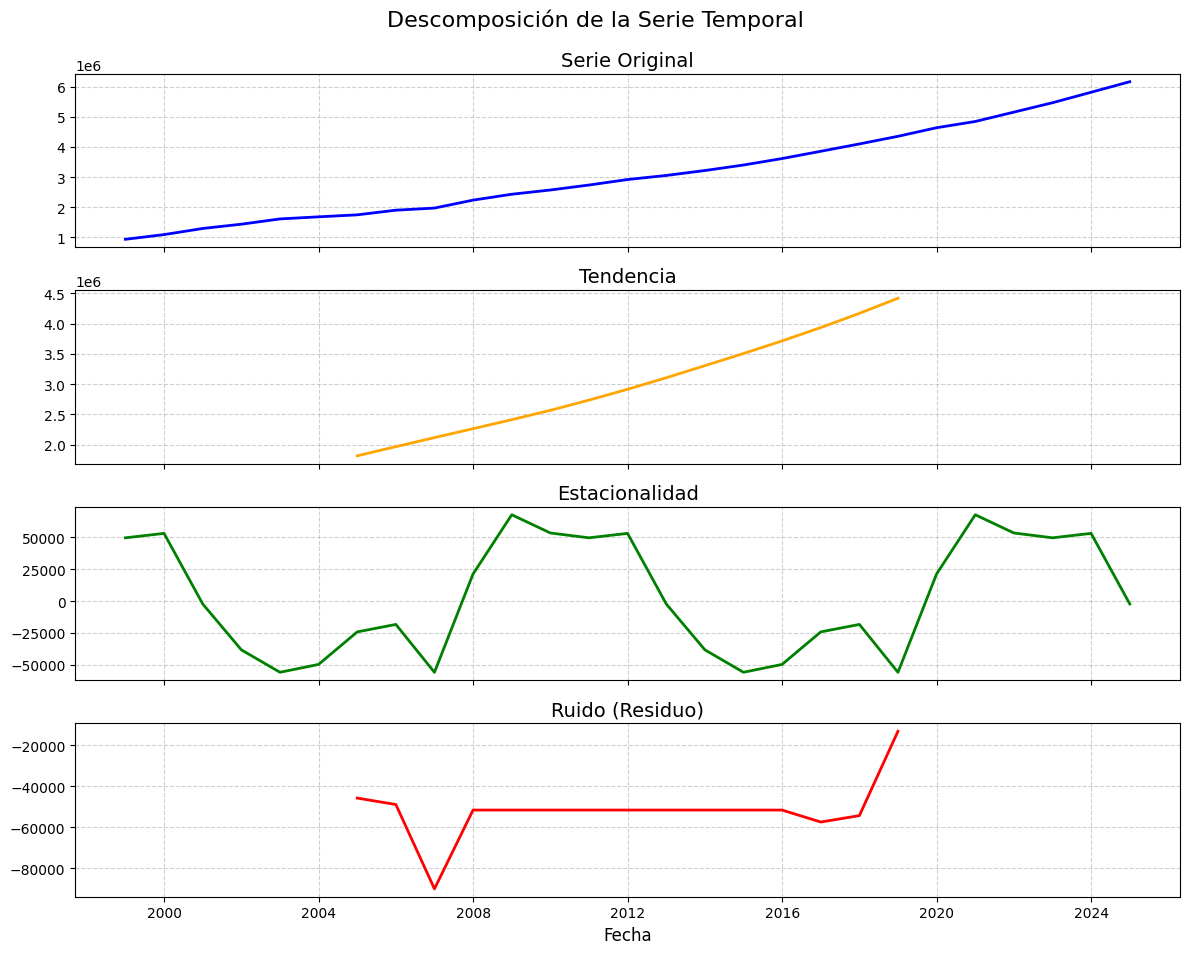

In [29]:
analisis_st.detectar_estacionalidad()

In [30]:
analisis_st.prueba_estacionariedad()

ADF Statistic: 6.443519495590372
p-value: 1.0
Valores Críticos:
1%: -3.7112123008648155
5%: -2.981246804733728
10%: -2.6300945562130176
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


In [31]:
modelo_arima = st.ARIMAModel()

parametros_arima = modelo_arima.generar_parametros(p_range=range(1,6), q_range=range(1,6))
parametros_arima[:5]

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

In [32]:
train_size= int(0.7 * len(df_autos_historicos))
df_autos_historicos.set_index('FECHA', inplace=True)
df_autos_historicos.index = pd.to_datetime(df_autos_historicos.index)
# df_autos_historicos = df_autos_historicos.asfreq('A')

y_train, y_test = df_autos_historicos[:train_size], df_autos_historicos[train_size:]

In [33]:
resultados_arima = modelo_arima.evaluar_modelos(y_train, y_test, parametros_arima, diferenciacion=1)
resultados_arima.head(3)

100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


,p,q,RMSE
0,1,1,632687
1,1,2,633129
2,1,3,637013


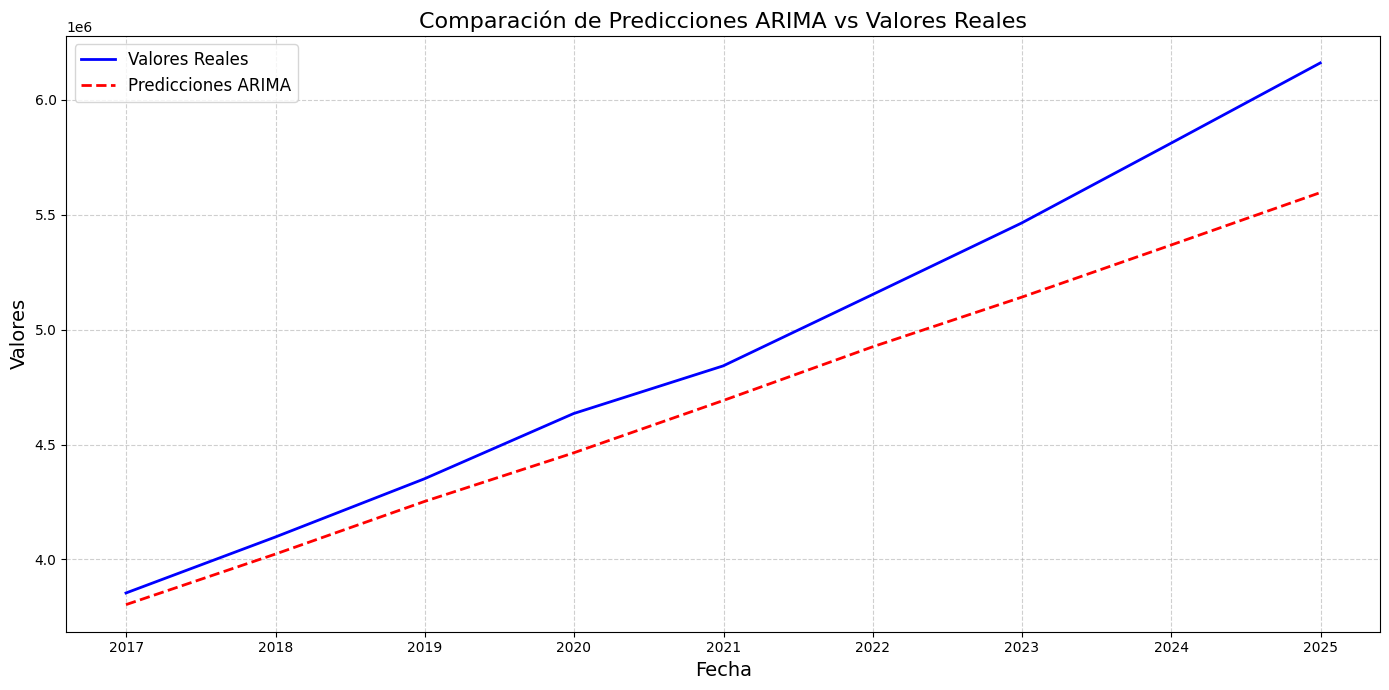

In [34]:
modelo_arima.visualizar_predicciones(y_test)

In [35]:
df_autos_historicos.head()

,Vehículos
FECHA,
1998-12-31,936083
1999-12-31,1090833
2000-12-31,1294998
2001-12-31,1436165
2002-12-31,1611023


In [36]:
df_autos_historicos.reset_index(inplace=True)
df_autos_historicos.columns = ['ds', 'y']

In [37]:
df_autos_historicos.head()

,ds,y
0,1998-12-31,936083
1,1999-12-31,1090833
2,2000-12-31,1294998
3,2001-12-31,1436165
4,2002-12-31,1611023


In [38]:
df_autos_historicos.tail()

,ds,y
22,2020-12-31,4842367
23,2021-12-31,5152448
24,2022-12-31,5463996
25,2023-12-31,5810888
26,2024-12-31,6160988


In [39]:
m = Prophet()
m.fit(df_autos_historicos)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=2, freq='Y') 
m.predict(future)

01:44:44 - cmdstanpy - INFO - Chain [1] start processing
01:44:44 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1998-12-31,662029,913184,1010877,662029,662029,297142,297142,297142,297142,297142,297142,0,0,0,959171
1,1999-12-31,811432,1077395,1170440,811432,811432,312234,312234,312234,312234,312234,312234,0,0,0,1123665
2,2000-12-31,961244,1218688,1313622,961244,961244,305977,305977,305977,305977,305977,305977,0,0,0,1267220
3,2001-12-31,1110558,1357726,1447247,1110558,1110558,295056,295056,295056,295056,295056,295056,0,0,0,1405614
4,2002-12-31,1237511,1489868,1581320,1237511,1237511,297142,297142,297142,297142,297142,297142,0,0,0,1534653
5,2003-12-31,1364241,1629395,1720167,1364241,1364241,312234,312234,312234,312234,312234,312234,0,0,0,1676475
6,2004-12-31,1491318,1752945,1843359,1491318,1491318,305977,305977,305977,305977,305977,305977,0,0,0,1797295
7,2005-12-31,1618048,1865753,1958427,1618048,1618048,295056,295056,295056,295056,295056,295056,0,0,0,1913104
8,2006-12-31,1744804,1997974,2084854,1744804,1744804,297142,297142,297142,297142,297142,297142,0,0,0,2041946
9,2007-12-31,1914753,2181342,2270862,1914753,1914753,312234,312234,312234,312234,312234,312234,0,0,0,2226987


In [40]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
24,2022-12-31,5491881,5447199,5538999
25,2023-12-31,5800888,5751213,5846552
26,2024-12-31,6089352,6046208,6137523
27,2025-12-31,6372347,6327999,6417654
28,2026-12-31,6668348,6619114,6717754


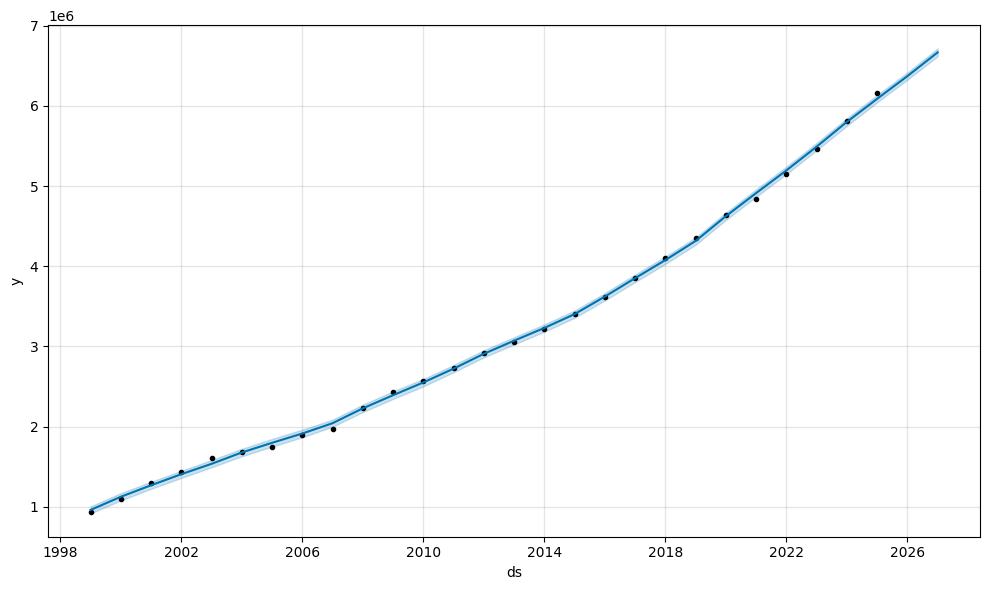

In [41]:
fig1 = m.plot(forecast)

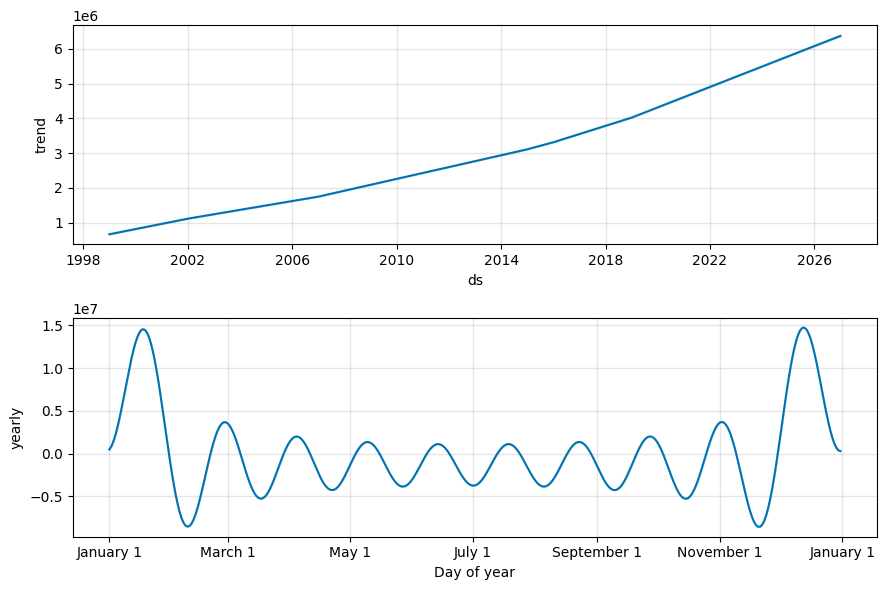

In [42]:
fig2 = m.plot_components(forecast)

In [43]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [44]:
plot_components_plotly(m, forecast)